<table width="100%" style="border: none; border-collapse: collapse; margin: 0; padding: 0;">
<tr style="border: none; background: none;">
<td width="50%" style="border: none; border-bottom: 2px solid #555555; vertical-align: top; padding-bottom: 10px; text-align: left;">
<h2 style="margin: 0; padding: 0; line-height: 1;"><span style="color: #B30033;">▍</span> Práctica 3:</h2>
<h1 style="margin: 5px 0 0 0; font-size: 200%; line-height: 1.2;">Aprendizaje de modelos basados en redes neuronales</h1>
</td>
<td width="50%" style="border: none; border-bottom: 2px solid #555555; vertical-align: bottom; padding-bottom: 10px; text-align: right;">
<div style="display: inline-block; border-left: 2px solid #555555; padding-left: 15px; text-align: right;">
<p style="margin: 0 0 10px 0; font-size: 140%; font-weight: bold;">Minería de Datos, 2025-26</p>
<p style="margin: 0; font-size: 100%; color: #666666;">José Antonio Gámez Martín<a href="mailto:Jose.Gamez@uclm.es" style="color: #888888; text-decoration: none; margin-left: 10px; font-size: 80%;">✉ Jose.Gamez@uclm.es</a></p>
<p style="margin: 5px 0 0 0; font-size: 100%; color: #666666;">Pablo Torrijos Arenas<a href="mailto:Pablo.Torrijos@uclm.es" style="color: #888888; text-decoration: none; margin-left: 10px; font-size: 80%;">✉ Pablo.Torrijos@uclm.es</a></p>
</div>
</td>
</tr>
</table>
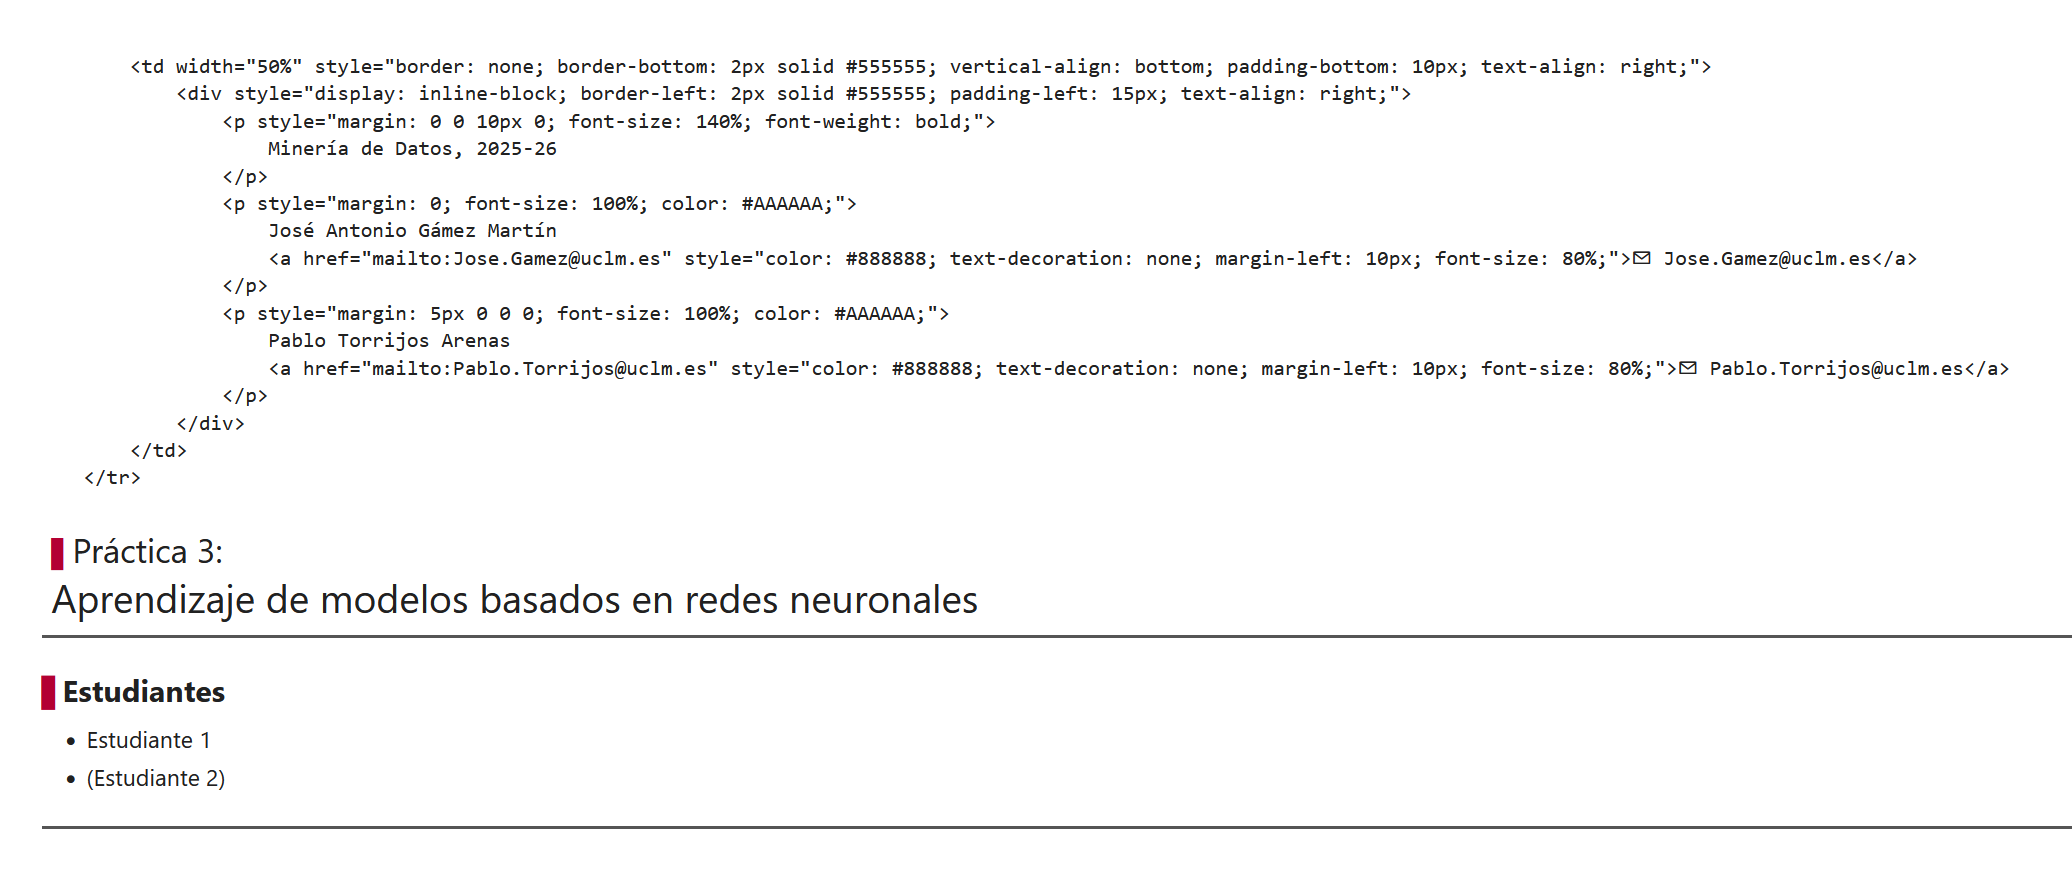

<h3 style="margin: 0 0 10px 0; font-weight: bold;">
<span style="color: #B30033; font-size: 120%; margin-right: 5px;">▍</span>Estudiantes</h3>

* Agustín Prieto Páez
* Jesús Sanz Alonso

## 1. Introducción

En esta práctica aplicaremos **Deep Learning** para clasificar imágenes satelitales del conjunto de datos **EuroSAT**. El objetivo es identificar el uso del suelo (bosques, zonas industriales, cultivos, etc.) utilizando tanto redes diseñadas desde cero como técnicas de Transfer Learning.

### Instrucciones de Dataset (Kaggle)
Para que esta libreta funcione, debes añadir el siguiente dataset a tu entorno (en principio, si clonais la libreta lo deberíais de tener por defecto):
1.  En el menú derecho, pulsa **Add Input**.
2.  Busca **"EuroSAT Dataset"** (del usuario *Gota Dahiya*).
3.  Añádelo pulsando el botón `+`.

### Configuración Inicial
Asegúrate de tener activada la **GPU** (T4 x2 o P100) para acelerar el entrenamiento.

In [1]:
!pip install "protobuf==3.20.3" > /dev/null 2>&1  #Si no, da un error de compatibilidad entre liberías.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pathlib
import PIL.Image
import time
from sklearn.metrics import classification_report, confusion_matrix

2025-12-06 14:53:30.256677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765032810.448003      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765032810.499151      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Reproducibilidad
SEED = 2025
tf.random.set_seed(SEED)
np.random.seed(SEED)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.18.0
GPU Available: True


---

## 2. Carga y Gestión de Datos

Utilizaremos `tf.keras.utils.image_dataset_from_directory`. Esta función crea un generador de datos que carga las imágenes del disco bajo demanda, evitando saturar la memoria RAM.

In [3]:
# Ruta estándar basada en el dataset eurosat-dataset. Contiene las imágenes .jpg, mientras que 'EuroSATallBands' contiene archivos .tif
data_dir = pathlib.Path('/kaggle/input/eurosat-dataset/EuroSAT')

# Verificación del contenido
all_images = list(data_dir.glob('*/*.jpg'))
image_count = len(all_images)
print(f"Total de imágenes encontradas: {image_count}")

# Verificación de dimensiones reales
first_image = PIL.Image.open(all_images[0])
print(f"Dimensiones reales de una imagen de muestra: {first_image.size}")
print(f"Formato de imagen: {first_image.format}")

# Parámetros Globales
# Ajustamos las constantes al tamaño real detectado (debería ser 64x64)
BATCH_SIZE = 64
IMG_HEIGHT = 64
IMG_WIDTH = 64

Total de imágenes encontradas: 27000
Dimensiones reales de una imagen de muestra: (64, 64)
Formato de imagen: JPEG


### 2.1 Creación de Pipelines (`tf.data`) y División Train/Val/Test

Para garantizar la robustez de los resultados, dividiremos los datos de la siguiente manera:
* **70% Entrenamiento:** Para ajustar los pesos de los modelos.
* **15% Validación:** Para ajustar hiperparámetros y *Early Stopping*.
* **15% Test:** Conjunto para la evaluación final.

In [4]:
# Cargamos el dataset completo sin dividir inicialmente
full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode='int'
)

class_names = full_ds.class_names
print(f"Clases encontradas: {class_names}")

# Calculamos el número de batches
n_batches = tf.data.experimental.cardinality(full_ds).numpy()

train_size = int(0.7 * n_batches)
val_size = int(0.15 * n_batches)
test_size = n_batches - train_size - val_size

print(f"Batches -> Train: {train_size}, Val: {val_size}, Test: {test_size}")

# Realizar la división usando take() y skip()
train_ds = full_ds.take(train_size)
remaining_ds = full_ds.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

Found 27000 files belonging to 10 classes.


I0000 00:00:1765032845.694933      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765032845.695506      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Clases encontradas: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Batches -> Train: 295, Val: 63, Test: 64


### 2.2 Optimización (Performance)
Usamos `.cache()` y `.prefetch()` para que la GPU no tenga que esperar a la carga de datos.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 2.3 Análisis Exploratorio (EDA)
En esta práctica no nos vamos a centar en el EDA y preprocesamiento. Solo se piden (obligatoriamente) las siguientes tareas:

**Tarea:**
1.  Visualiza una cuadrícula de imágenes del conjunto de entrenamiento con sus etiquetas (preferiblemente mostrando alguna de cada clase).
2.  Analiza si el dataset está balanceado mostrando un gráfico de barras con la cantidad de imágenes por clase.

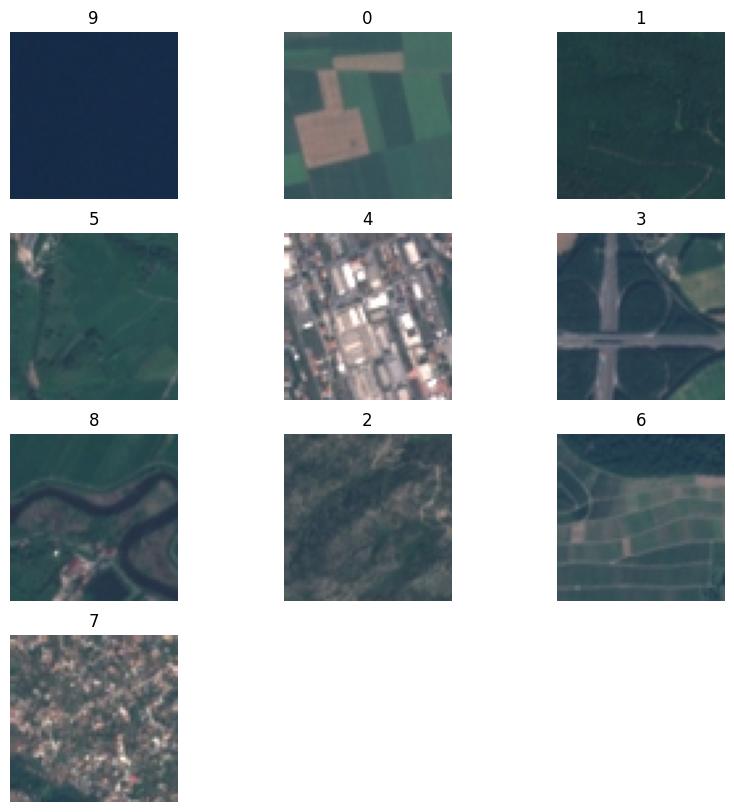

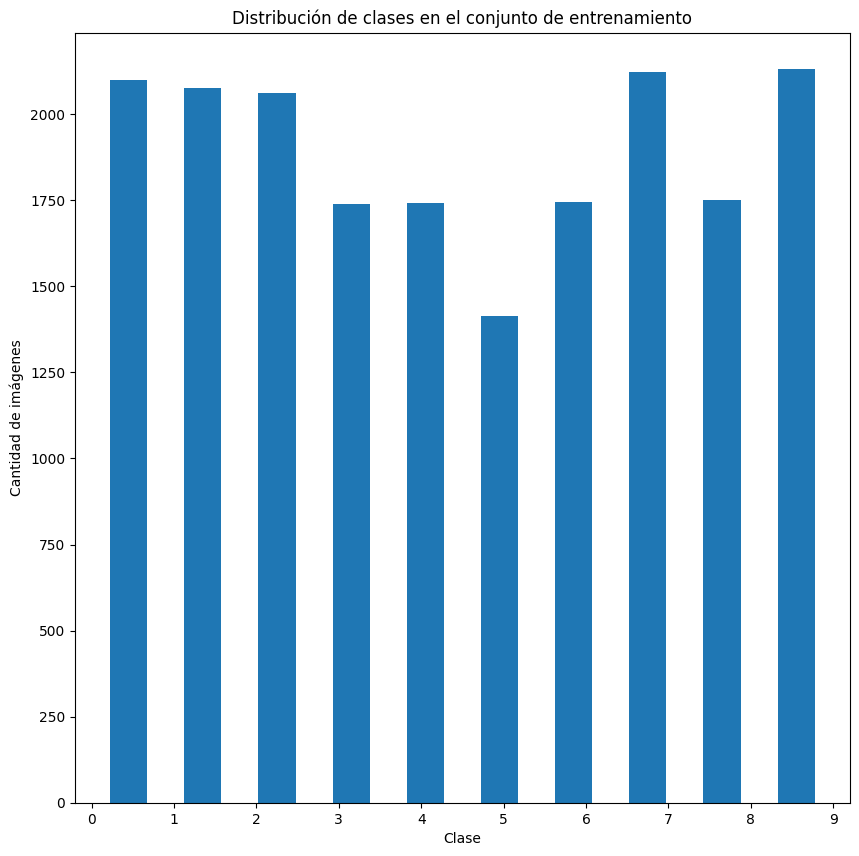

In [6]:
import numpy as np

# Obtiene las clases y sus índices
class_names = np.unique(np.concatenate([y for x, y in train_ds]))
num_classes = len(class_names)

# Visualiza una cuadrícula de imágenes
list_ =[]
plt.figure(figsize=(10, 10))
j = 0
for images, labels in train_ds.take(1):
    for i in range(len(images)):
        if class_names[labels[i].numpy()] not in list_:
            ax = plt.subplot(4, 3, j + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
            list_.append(class_names[labels[i].numpy()])
            j += 1
plt.show()
# Analiza si el dataset está balanceado
labels = []
for _, label in train_ds:
    labels.extend(label.numpy())

plt.figure(figsize=(10, 10))
plt.hist(labels, bins=num_classes, align='mid', rwidth=0.5)
plt.xticks(class_names)
plt.xlabel('Clase')
plt.ylabel('Cantidad de imágenes')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.show()

Aunque parezca que no hay 10 barras, sí las hay. Las clases (del 0 al 9) no están bien mapeadas con las barras del histograma.

---
## 3. Baseline: Perceptrón Multicapa (MLP)

Antes de usar redes convolucionales, diseñaremos una red densa clásica (`Sequential`) como baseline para comprobar las limitaciones de tratar imágenes como datos tabulares planos.

**Requisitos:**
1.  La red debe comenzar normalizando los valores de entrada ($0-1$) y aplanando la imagen para convertir la matriz 3D en un vector 1D.
2.  Eres libre de elegir la profundidad y anchura de la red. Ten en cuenta que la entrada tiene más de $12.000$ dimensiones ($64 \times 64 \times 3$).
3.  Configura correctamente la última capa para un problema de clasificación de 10 clases.
4.  Compila el modelo utilizando el optimizador `adam` y la función de pérdida `sparse_categorical_crossentropy`.
5.  Se recomienda guardar el **tiempo de entrenamiento**, en este y todos los modelos, para posibles comparaciones posteriores.
6.  Guarda el mejor modelo generado como `best_mlp.keras`.

**Evaluación:**
1.  Utiliza `accuracy` como métrica de monitorización. Pensad por qué podemos usar esta métrica.
2.  Genera y analiza las gráficas de `loss` y `accuracy` (Entrenamiento vs. Validación).
3.  **Pregunta:** ¿Por qué, teóricamente, un MLP no es la arquitectura ideal para este problema comparado con una CNN?

In [7]:
# TODO

---
## 4. Arquitectura Propia: Red Neuronal Convolucional (CNN)

Ahora diseñarás una arquitectura adaptada específicamente para el procesamiento de imágenes. Tu objetivo es **superar el rendimiento del Baseline (MLP)** aprovechando la capacidad de las CNN para aprender patrones espaciales y texturas.

Eres libre de definir la profundidad de la red y el número de filtros, pero debes cumplir los siguientes **requisitos**:
1.  **Data Augmentation:** Incluye capas de preprocesamiento al inicio (ej. `RandomFlip`, `RandomRotation`) para mejorar la generalización.
2.  **Estructura:** Se recomienda usar bloques repetitivos de `Conv2D` $\rightarrow$ `MaxPooling2D`.
    * *Advertencia:* Las imágenes son de $64 \times 64$. Si abusas de las capas de *pooling*, reducirás la imagen a $1 \times 1$ antes de tiempo, perdiendo información.
3.  **Regularización:** Es obligatorio implementar `Dropout` y/o `BatchNormalization` para reducir el sobreajuste. Experimenta con su posición y valores.
4.  **Callbacks:** Configura `EarlyStopping` y `ModelCheckpoint`.

**Tarea:**
1.  Diseña, compila y entrena tu modelo.
2.  Compara las curvas de aprendizaje con las del MLP. ¿Converge más rápido? ¿Sufre menos sobreajuste?
3.  Guarda el mejor modelo generado como `best_cnn.keras`.
4.  Compara el ratio entre tamaño del modelo y accuracy del modelo generado (CNN) con el MLP anterior.
5.  Se valorará el estudio de la influencia del aumento de datos y del uso de `Dropout` y/o `BatchNormalization`.

In [8]:
# TODO

---
## 5. Transfer Learning (Estado del Arte)

En esta sección, utilizaremos una red preentrenada en ImageNet para aprovechar el conocimiento extraído de millones de imágenes. Dado el tamaño de entrada ($64 \times 64$), buscamos arquitecturas eficientes que no reduzcan excesivamente la dimensionalidad espacial.

Debes construir un nuevo modelo siguiendo estas **pautas**:
1.  Integra la misma capa de aumento de datos definida en la sección anterior.
2.  Importa una arquitectura robusta (como `ResNet50V2` o `EfficientNetV2B0`) con pesos de `imagenet`. Recuerda configurar `include_top=False` y definir el `input_shape` correcto.
3.  Congela los pesos del modelo base (Feature Extraction) y añade tu(s) propia(s) capa(s) completamente contectada(s) para clasificación. Se recomienda usar `GlobalAveragePooling2D` para conectar la base convolucional con la capa de salida.

**Tarea:**
1.  Construye, compila y entrena el modelo.
2.  Guarda el mejor modelo generado como `best_transfer.keras`.
3.  Analiza si el uso de modelos preentrenados justifica la mejora en precisión respecto a tu CNN "artesanal", considerando el tiempo de entrenamiento y el número de parámetros.
4.  Se valorará el estudio de descongelar los últimos bloques del modelo base para realizar un *Fine-Tuning* con una tasa de aprendizaje reducida (ej. $1e-5$).

In [9]:
# TODO

---
## 6. (Opcional) Nuevas Fronteras: Vision Transformers (ViT)

Mientras que las CNN han dominado la visión por computador durante una década, los **Transformers** (originalmente diseñados para texto) han irrumpido con fuerza en el campo.

A diferencia de una CNN, que mira píxeles vecinos, un **Vision Transformer (ViT)** divide la imagen en "parches" (por ejemplo, cuadrados de $16 \times 16$) y procesa la relación de cada parche con todos los demás simultáneamente mediante mecanismos de **Atención**.

**Desafío Técnico:**
Los ViT son modelos muy pesados y requieren una resolución de entrada específica (generalmente $224 \times 224$). Además, su integración en Keras requiere adaptadores especiales.

**Tarea (Bonus):**
1.  Instala la librería `transformers` de Hugging Face.
2.  Utiliza la clase `ViTWrapper` proporcionada abajo para cargar un modelo base de Google (`vit-base-patch16-224`).
3.  **Completa la función `build_vit_classifier`**:
    * Añade tu capa de **Data Augmentation** al inicio.
    * Observa cómo adaptamos la imagen (`Resizing`, `Rescaling` y `Permute`) para que sea compatible con el modelo de Google.
    * Añade tu(s) propia(s) capa(s) completamente contectada(s) de clasificación al final (Capas Densas y de Salida).
4.  Entrena por pocas épocas y compara los resultados (y el tiempo de ejecución) con tu mejor CNN.

In [10]:
from transformers import TFViTModel
from tensorflow.keras import layers, models

# --- CLASE DE UTILIDAD PROPORCIONADA ---
# Esta capa envuelve el modelo de Hugging Face para evitar errores de compatibilidad con Keras 3
class ViTWrapper(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Cargamos el modelo base pre-entrenado
        self.vit = TFViTModel.from_pretrained('google/vit-base-patch16-224')
        self.vit.trainable = False # Congelamos pesos base
        
    def call(self, inputs):
        # El modelo espera 'pixel_values'
        # Retornamos 'pooler_output' que es la representación vectorial de la imagen
        return self.vit(pixel_values=inputs).pooler_output

# --- CLASIFICADOR INCOMPLETO ---
def build_vit_classifier():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    # 1. Data Augmentation
    # TODO: Añade aquí tu capa de aumento de datos
    
    # 2. Adaptación de Dimensionalidad (Necesario para ViT)
    # Redimensionamos a 224x224 (resolución nativa de ViT)
    x = layers.Resizing(224, 224)(x)
    # Escalamos los píxeles entre -1 y 1
    x = layers.Rescaling(1./127.5, offset=-1)(x)
    # Transponemos canales a (Canales, Alto, Ancho) para compatibilidad con Hugging Face
    x = layers.Permute((3, 1, 2))(x)
    
    # 3. Bloque Transformer
    x = ViTWrapper()(x)
    
    # 4. Clasificación
    # TODO: Añade las capas densas y la capa de salida (Softmax)
    
    return keras.Model(inputs, outputs, name="ViT")

# TODO: Compilar y Entrenar

---
## 7. Evaluación y Análisis Comparativo

En esta sección final evaluaremos el mejor modelo y realizaremos un estudio comparativo de todas las arquitecturas probadas.

**Tareas:**
1.  **Evaluación Cuantitativa:**
    * Carga el mejor modelo de todos los generados.
    * Genera el `classification_report` para ver la precisión, recall y F1-score por cada clase.
    * Visualiza la **Matriz de Confusión**. Identifica los pares de clases más problemáticos.

2.  **Análisis Cualitativo de Errores:**
    * Visualiza algunas imágenes mal clasificadas. 
    * **Requisito:** Muestra la imagen, la etiqueta real, la etiqueta predicha y el **nivel de confianza** (probabilidad) del modelo en esa predicción errónea. ¿Son errores "evitables"?

3.  **Comparativa Final:**
    * Crea un DataFrame de Pandas comparando al menos MLP, CNN Propia y CNN Transfer Learning (opcional ViT). *En este punto se pueden incluir también comparaciones con modelos con/sin aumento de datos, con/sin dropout, diversas arquitecturas...*
    * Ejemplo de columnas: `Modelo`, `Accuracy (Val)`, `F1-Score (Macro)`, `Nº Parámetros`, `Nº Parámetros Entrenables`, `Tiempo de Entrenamiento`.
    * **Conclusión:** Escribe un par de párrafos justificando cuál es la mejor arquitectura considerando el equilibrio entre recursos computacionales (parámetros/tiempo) y precisión.

In [11]:
# TODO